In [2]:
import numpy as np
import pandas as pd

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

## Load datasets

In [3]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'

In [4]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

In [5]:
df_pca = pd.read_csv(dataset_path + dataset_name + dataset_pca_suffix + '.csv', index_col=0)
X_pca = df_pca.drop('type', axis=1)
y_pca = df_pca.type

### Oversampling

In [6]:
smt = SMOTE(random_state=42)
X_norm_res, y_norm_res = smt.fit_resample(X_norm, y_norm)
X_pca_res, y_pca_res = smt.fit_resample(X_pca, y_pca)

## Train

In [31]:
def train(X, y, n_neighbors=4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # create model instance
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    # fit model
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    return preds, y_test

### Experiment with neighbor count

In [33]:
def experiment(n_neighbors=4):
    norm_pred, norm_real = train(X_norm, y_norm, n_neighbors=n_neighbors)
    pca_pred, norm_real = train(X_pca, y_pca, n_neighbors=n_neighbors)
    norm_res_pred, norm_res_real = train(X_norm_res, y_norm_res, n_neighbors=n_neighbors)
    pca_res_pred, pca_res_real = train(X_pca_res, y_pca_res, n_neighbors=n_neighbors)

    print('Number of neighbors: ', n_neighbors)

    # Original dataset
    print('Accuracy of normalized dataset: ', accuracy_score(norm_pred, norm_real))
    print('Accuracy of PCA dataset: ', accuracy_score(pca_pred, norm_real))

    # Oversampled dataset
    print('Accuracy of normalized oversampled dataset: ', accuracy_score(norm_res_pred, norm_res_real))
    print('Accuracy of PCA oversampled dataset: ', accuracy_score(pca_res_pred, pca_res_real))

    print('\n')

for n_neighbors in range(1, 10):
    experiment(n_neighbors)

Number of neighbors:  1
Accuracy of normalized dataset:  0.6774193548387096
Accuracy of PCA dataset:  0.8064516129032258
Accuracy of normalized oversampled dataset:  0.9
Accuracy of PCA oversampled dataset:  0.94


Number of neighbors:  2
Accuracy of normalized dataset:  0.7419354838709677
Accuracy of PCA dataset:  0.7419354838709677
Accuracy of normalized oversampled dataset:  0.92
Accuracy of PCA oversampled dataset:  0.96


Number of neighbors:  3
Accuracy of normalized dataset:  0.7096774193548387
Accuracy of PCA dataset:  0.7741935483870968
Accuracy of normalized oversampled dataset:  0.88
Accuracy of PCA oversampled dataset:  0.9


Number of neighbors:  4
Accuracy of normalized dataset:  0.7419354838709677
Accuracy of PCA dataset:  0.7419354838709677
Accuracy of normalized oversampled dataset:  0.9
Accuracy of PCA oversampled dataset:  0.92


Number of neighbors:  5
Accuracy of normalized dataset:  0.7096774193548387
Accuracy of PCA dataset:  0.7096774193548387
Accuracy of normal

In [37]:
norm_pred, norm_real = train(X_norm, y_norm, n_neighbors=2)
pca_pred, norm_real = train(X_pca, y_pca, n_neighbors=2)

In [38]:
norm_res_pred, norm_res_real = train(X_norm_res, y_norm_res, n_neighbors=2)
pca_res_pred, pca_res_real = train(X_pca_res, y_pca_res, n_neighbors=2)

## Results

In [39]:
# Original dataset
print('Accuracy of normalized dataset: ', accuracy_score(norm_pred, norm_real))
print('F1 Score of normalized dataset: ', f1_score(norm_pred, norm_real, average='weighted'))
print('Accuracy of PCA dataset: ', accuracy_score(pca_pred, norm_real))
print('F1 Score of PCA dataset: ', f1_score(pca_pred, norm_real, average='weighted'))

Accuracy of normalized dataset:  0.7419354838709677
F1 Score of normalized dataset:  0.7934272857872178
Accuracy of PCA dataset:  0.7419354838709677
F1 Score of PCA dataset:  0.7661290322580645


In [40]:
# Oversampled dataset
print('Accuracy of normalized oversampled dataset: ', accuracy_score(norm_res_pred, norm_res_real))
print('F1 Score of normalized oversampled dataset: ', f1_score(norm_res_pred, norm_res_real, average='weighted'))
print('Accuracy of PCA oversampled dataset: ', accuracy_score(pca_res_pred, pca_res_real))
print('F1 Score of PCA oversampled dataset: ', f1_score(pca_res_pred, pca_res_real, average='weighted'))

Accuracy of normalized oversampled dataset:  0.92
F1 Score of normalized oversampled dataset:  0.9191919191919191
Accuracy of PCA oversampled dataset:  0.96
F1 Score of PCA oversampled dataset:  0.96


## Plot

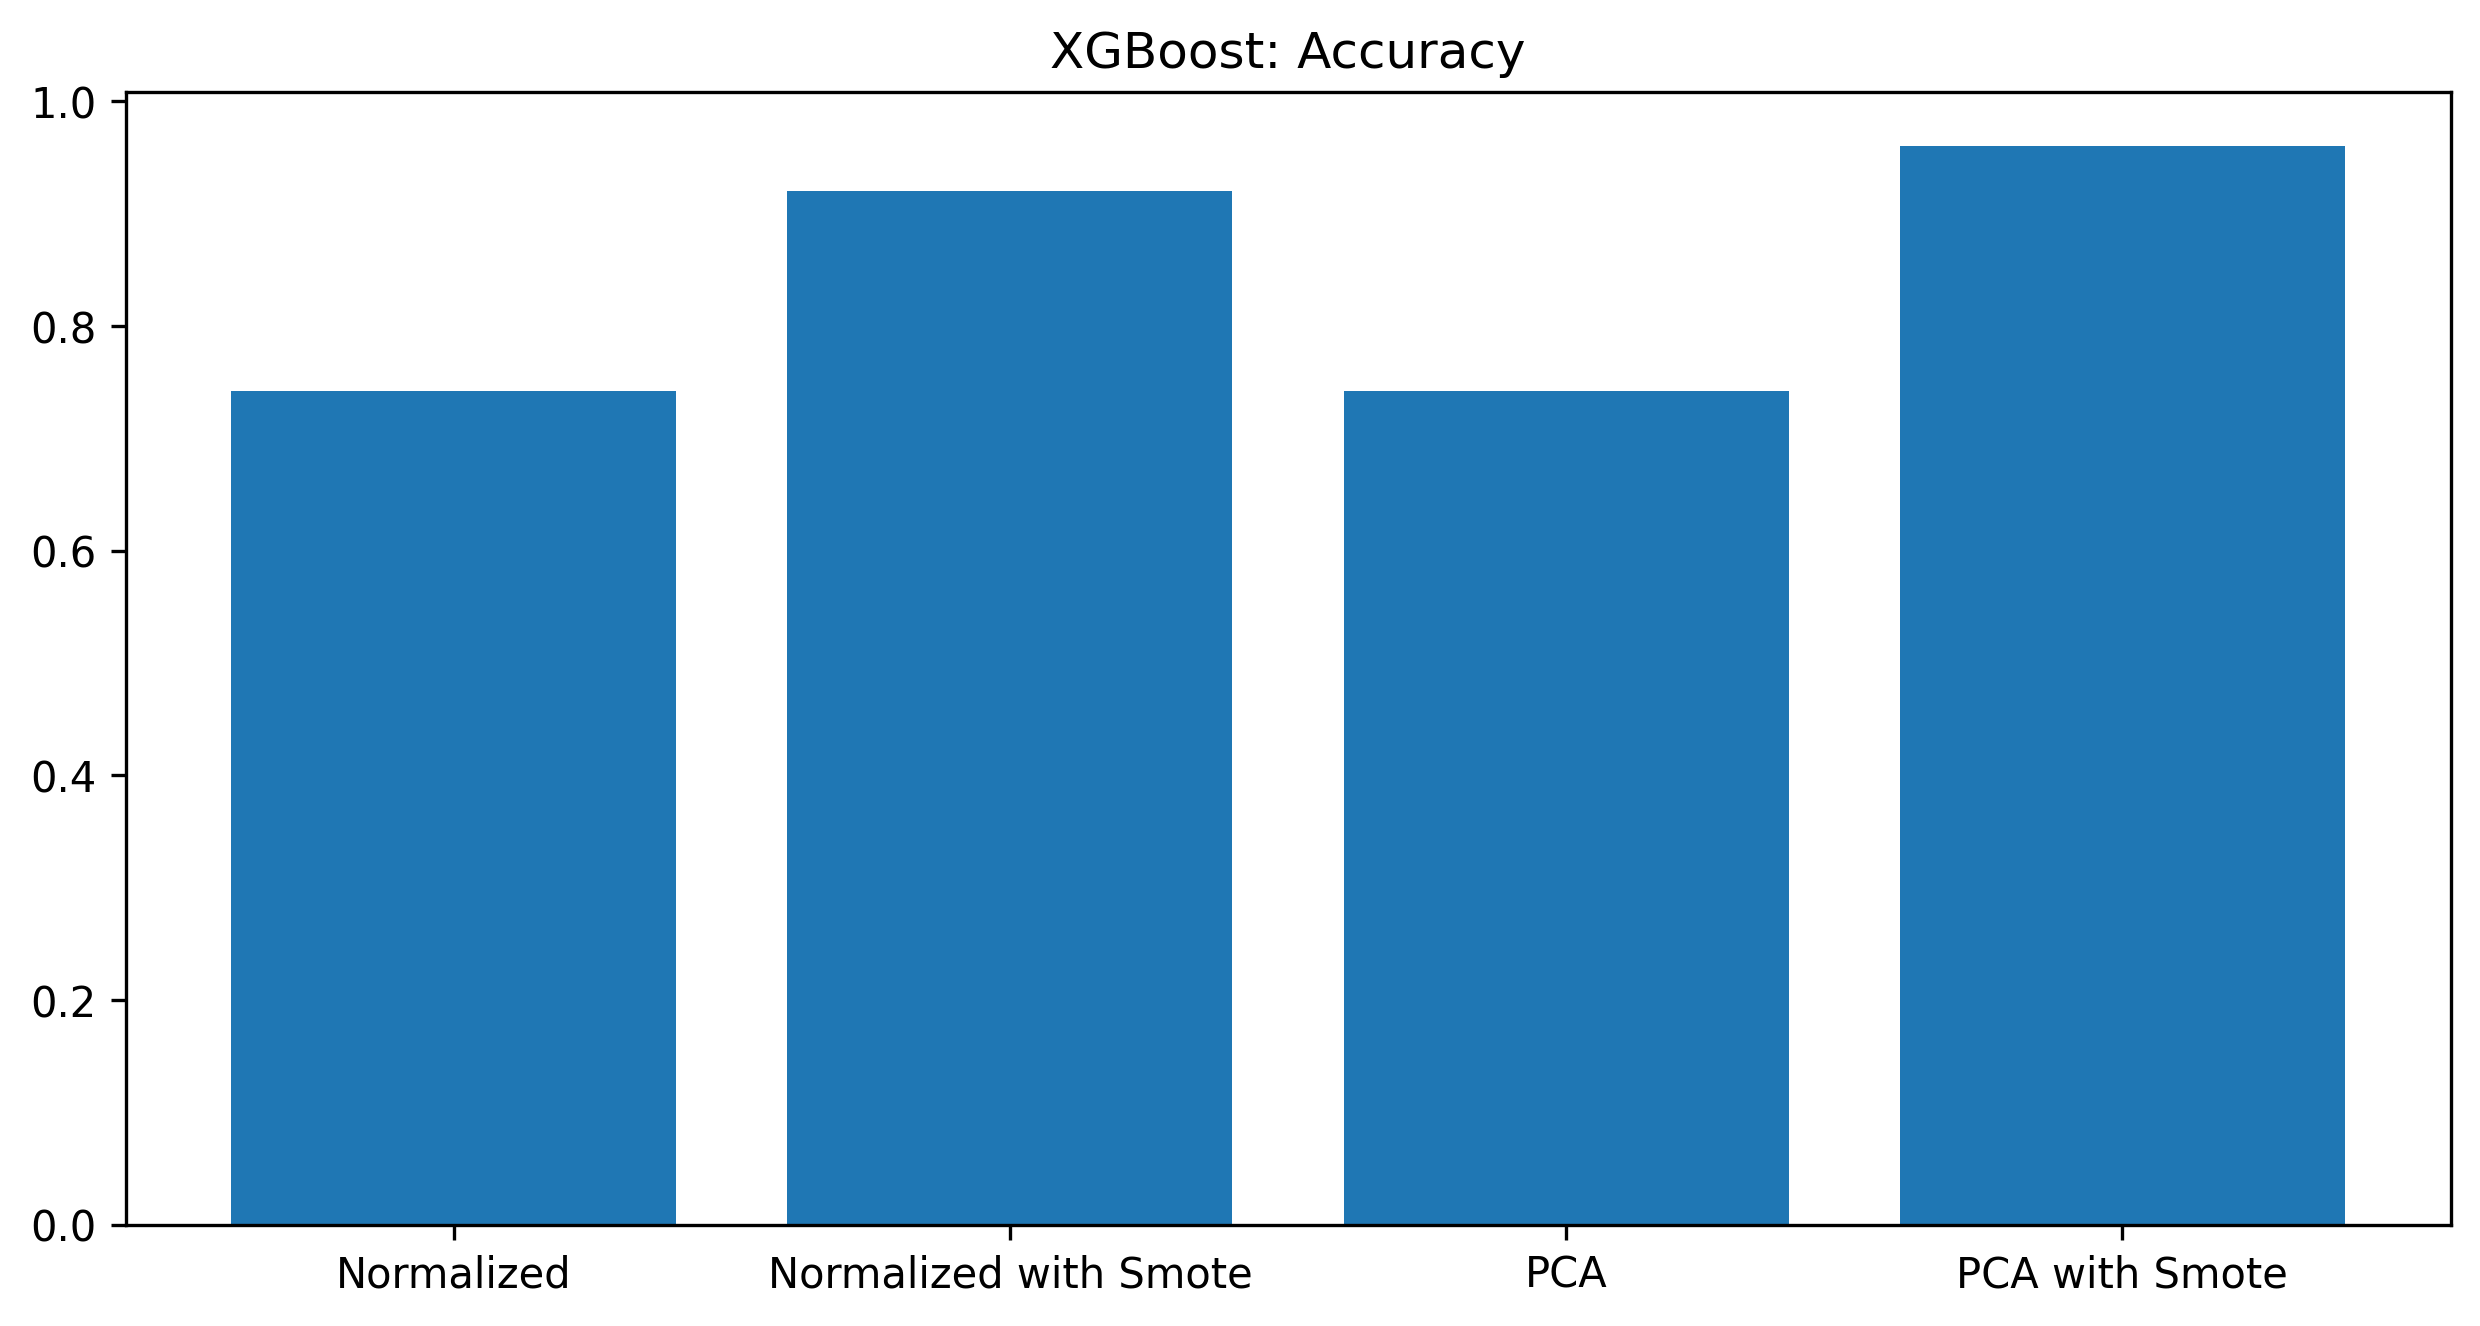

In [41]:
# Plot accuracy
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        accuracy_score(norm_pred, norm_real), 
        accuracy_score(norm_res_pred, norm_res_real), 
        accuracy_score(pca_pred, norm_real), 
        accuracy_score(pca_res_pred, pca_res_real)
    ]
)
plt.title('XGBoost: Accuracy')
plt.show()

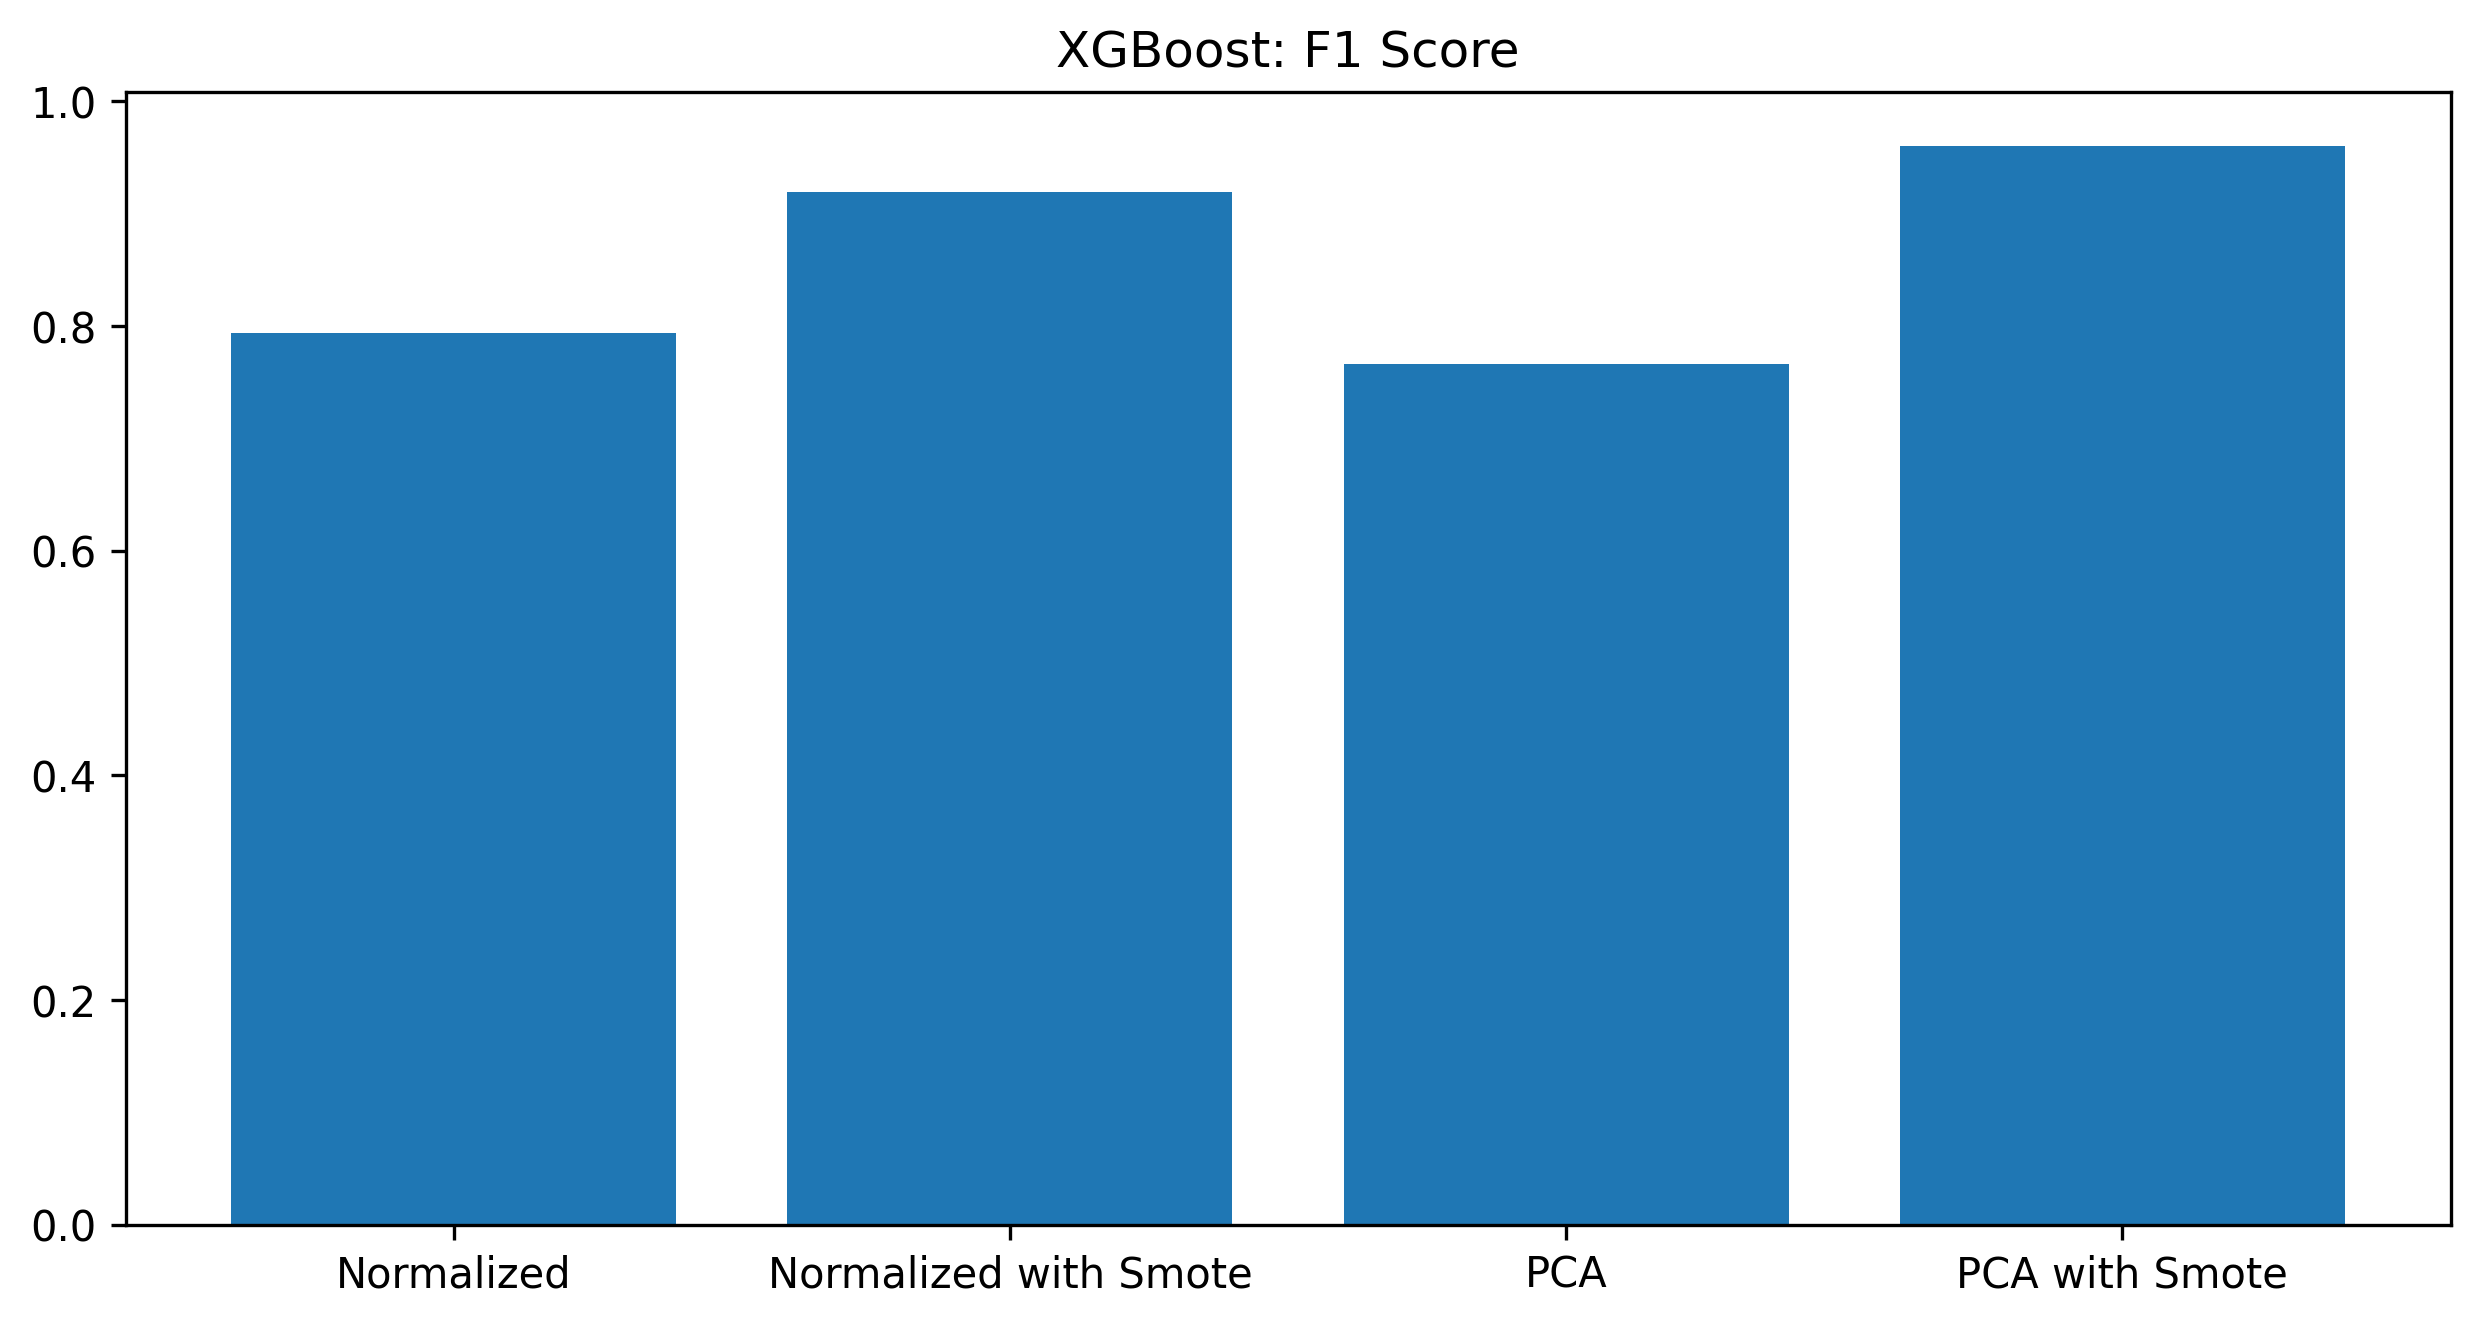

In [42]:
# Plot F1 score

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        f1_score(norm_pred, norm_real, average='weighted'), 
        f1_score(norm_res_pred, norm_res_real, average='weighted'), 
        f1_score(pca_pred, norm_real, average='weighted'), 
        f1_score(pca_res_pred, pca_res_real, average='weighted')
    ]
)
plt.title('XGBoost: F1 Score')
plt.show()